# Competitive Pokemon Analysis

While in the traditional pokemon games, players raise Pokemon to complete an adventure, competitive Pokemon is a game where players strategically construct teams of pokemon with moves, natures, items, etc of their choosing to beaet other live players.  Not all Pokemon are equal for this purpose, so based on the usage statistics of the pokemon in competitive play, they are split into various tiers. A player may use a Pokemon to compete in a particular tier if the pokemon is in that tier or below. Historically, usage of various pokemon has changed overtime with the introduction of new pokemon, moves, abilities, and mechanics. So, Pokemon are constantly shifted between tiers to maintain balance.

In this analysis, we will attempt to classify pokemon into the competitive 6v6 tiers based on the properties of the Pokemon themselves.

## Table of Contents
1. [Preliminary Data Processing](#data-processing)
2. [Exploratory Data Analysis](#analysis)
    1. [Distribution of Tiers](#tier-distribution)
    2. [Pokemon Offensive/Defensive Stats](#poke-stats)
    3. [Types](#types)
    4. [Moves](#moves)



## Preliminary Data Processing <a class="anchor" id="data-processing"></a>

In [646]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [647]:
df = pd.read_csv('pokemon-data.csv', delimiter=';')
mdf = pd.read_csv('move-data.csv', delimiter=';')

print('Number of pokemon: ', len(df))
df.sample()

Number of pokemon:  918


,Name,Types,Abilities,Tier,HP,Attack,Defense,Special Attack,Special Defense,Speed,Next Evolution(s),Moves
81,Bronzong,"['Psychic', 'Steel']","['Heatproof', 'Heavy Metal', 'Levitate']",RU,67,89,116,79,116,33,[],"['Block', 'Block', 'Sunny Day', 'Rain Dance', ..."


In [648]:
print('Number of moves: ', len(mdf))
mdf.sample()

Number of moves:  728


,Index,Name,Type,Category,Contest,PP,Power,Accuracy,Generation
500,501,Quick Guard,Fighting,Status,Cool,15,None,None,5


In [649]:
#Preliminary Processing:
mdf.columns = ['index', 'name', 'type', 'category', 'contest', 'pp', 'power', 'accuracy', 'generation']
mdf.set_index('index')
mdf.sample()

df.columns = ['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'next_evos','moves']

#turn the lists into actual lists
df['next_evos'] = df.apply(lambda x: eval(x.next_evos), axis=1)
df['types'] = df.apply(lambda x: eval(x.types), axis=1)
df['abilities'] = df.apply(lambda x: eval(x.abilities), axis=1)
df['moves'] = df.apply(lambda x: eval(x.moves), axis=1)

The base stat total is a common metric players use to assess a Pokemon's overall strength, so let's create a column for this.

In [650]:
df['bst'] = df['hp'] + df['atk'] + df['def'] + df['spa'] + df['spd'] + df['spe']
df = df[['name', 'types', 'abilities', 'tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst', 'next_evos','moves']]
df.set_index('name', inplace=True)

The next evolution information is not immediately useful; however, we can determine how far a pokemon is in it's evolutionary chain. Notice that a pokemon can have one, two, or three evolutions in it's chain, along with the possibility of a mega evolution. A pokemon that is in its final form that after one evolution is not necessarily weaker or stronger than another after two evolutions. For each pokemon, let's store the length of the evolutionary chain (excluding mega evolutions) and it's stage in the chain. 

A mega evolution will be the stage of the pokemon + 1. For example, Blaziken would have a chain length of 3 and it would be in stage 3, while Mega Blaziken would have a chain length of 3 and it would be in stage 4. 

However, some pokemon have alternate forms listed as evolutions. Consider:

In [651]:
df[df.index == 'Giratina']

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evos,moves
name,,,,,,,,,,,,
Giratina,"[Dragon, Ghost]","[Pressure, Telepathy]",Uber,150,100,120,100,120,90,680,[Giratina-Origin],"[Dragon Breath, Scary Face, Ominous Wind, Anci..."


We shall treat alternate forms that have a BST that is strictly greater than its original as a mega evolution. Otherwise, it will be treated as equivalent to the original form.

In [652]:
def stage_in_evo(n):
    # returns number of evolutions before it
    #print(df[df['name'] == n]['name'])
    bool_arr = df.apply(lambda x: n in x['next_evos'] and (n+'-') not in x['next_evos'], axis=1) #gets index of previous evolution
    if '-Mega' in n: #mega evolutions
        return stage_in_evo(n.split('-')[0]) + 1 
    elif not any(bool_arr):
        return 1 # if there's nothing before it, it's the first
    else:
        return 1 + stage_in_evo(df.index[bool_arr][0])

def num_evos(n):
    if n not in df.index: #checks to ensure valid pokemon
        return n
    
    next_evos = df.loc[n, 'next_evos']
    if len(next_evos) > 0: #existence of next_evo
        if n in next_evos[0]: # if "next evo" is an alternate form
            return df.loc[n, 'stage'] #accounting for alternate forms
        else:
            return num_evos(next_evos[0])
    elif '-Mega' in n or n.split('-')[0] in df.index: 
        #this is checking if there is a pokemon with the same root name (e.g. Shaymin vs Shaymin-Sky)
        return df.loc[n.split('-')[0], 'stage']
    else:
        return df.loc[n, 'stage']

In [653]:
df['stage'] = df.apply(lambda x: stage_in_evo(x.name), axis=1)

In [654]:
df['num_evos'] = df.apply(lambda x: num_evos(x.name), axis=1)

In [655]:
df[(df.index == 'Landorus-Therian') | (df.index == 'Landorus') | (df.index == 'Monferno') | (df.index == 'Blaziken-Mega') | (df.index == 'Diglett-Alola')] #test

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evos,moves,stage,num_evos
name,,,,,,,,,,,,,,
Blaziken-Mega,"[Fire, Fighting]",[Speed Boost],Uber,80,160,80,130,80,100,630,[],"[Flare Blitz, Fire Punch, High Jump Kick, Scra...",4,3
Diglett-Alola,"[Ground, Steel]","[Sand Force, Sand Veil, Tangling Hair]",LC,10,55,30,35,45,90,265,[Dugtrio-Alola],"[Sand Attack, Metal Claw, Growl, Astonish, Mud...",1,2
Landorus,"[Flying, Ground]","[Sand Force, Sheer Force]",Uber,89,125,90,115,80,101,600,[Landorus-Therian],"[Outrage, Hammer Arm, Fissure, Block, Mud Shot...",1,1
Landorus-Therian,"[Flying, Ground]",[Intimidate],OU,89,145,90,105,80,91,600,[],"[Outrage, Hammer Arm, Fissure, Block, Mud Shot...",2,1
Monferno,"[Fighting, Fire]","[Blaze, Iron Fist]",NaN,64,78,52,78,52,81,405,[Infernape],"[Scratch, Leer, Mach Punch, Mach Punch, Scratc...",2,3


A large movepool is considered an asset in competitive pokemon. For many pokemon, a large movepool makes it hard to predict what mvoeset your opponent is running. Let's create another feature describing the number of moves in the movepool

In [656]:
df['num_moves'] = df.apply(lambda x: len(x.moves), axis=1)
df.sample()

,types,abilities,tier,hp,atk,def,spa,spd,spe,bst,next_evos,moves,stage,num_evos,num_moves
name,,,,,,,,,,,,,,,
Stoutland,[Normal],"[Intimidate, Sand Rush, Scrappy]",PU,85,110,90,45,90,80,500,[],"[Ice Fang, Fire Fang, Thunder Fang, Leer, Tack...",3,3,82


As of generation 7, there are 8 playable tiers. From strongest to weakest: Anything Goes (AG), Uber, Overused (OU), Underused (UU), Rarelyused (RU), Neverused (NU), Partiallyused (PU) and Little Cup (LC). There are also unplayable tiers called borderline tiers, suffixed by BL. These serve as banlists for their respective tiers (so these pokemon can only be used in higher tiers). For the purpose of this analysis, we will classify BL pokemon as the tier above.

We will not consider the Little Cup (LC) format, as they are not defined by usage statistics (it involves pokemon that are not evolved but are capable of evolution and can be obtained in the traditional games at level 5). We will also discard the AG tier, as it was created solely for Mega Rayquaza. Both Pokemon that belong to no tier because they are uncompetitive and pokemon in the Limbo tier becuase they are unreleased will not be considererd.

Let's make these changes. Also, we shall number the tiers to make plotting easier (lower number => better tier)

In [657]:
df.loc[df.tier == 'OUBL','tier'] = 'Uber'
df.loc[df.tier == 'UUBL','tier'] = 'OU'
df.loc[df.tier == 'RUBL','tier'] = 'UU'
df.loc[df.tier == 'NUBL','tier'] = 'RU'
df.loc[df.tier == 'PUBL','tier'] = 'NU'
df = df[df['tier'].isin(['Uber', 'OU', 'UU', 'NU', 'RU', 'PU'])]

In [658]:
tiers = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU']
tier_mapping = {tier:num for num, tier in enumerate(tiers)}
df['tier_num'] = df.apply(lambda x: tier_mapping[x.tier], axis=1)
tier_mapping

{'NU': 4, 'OU': 1, 'PU': 5, 'RU': 3, 'UU': 2, 'Uber': 0}

After inspecting the moves of each pokemon, there is an interest a couple interesting quirks in how the data was stored. First:

In [659]:
weird_moves = set()

for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            weird_moves.add(move)
            
print(weird_moves)

{"Trick'or'Treat", "Freeze'Dry", "Lock'On", "Soft'Boiled", "Multi'Attack", "King's Shield", "Topsy'Turvy", "Forest's Curse", "U'turn", "Mud'Slap", "Land's Wrath", "Wake'Up Slap", "Self'Destruct", "X'Scissor", "Will'O'Wisp", "Power'Up Punch", "Baby'Doll Eyes", "Double'Edge", "Nature's Madness"}


Many of these moves, such as U-turn, should have a dash instead of an apostrophe (according to the moves dataset). Upon closer inspection, it's clear that the only moves that should have an apostrophe are those whose words end with an apostrophe s. Let's make this correction.

In [660]:
weird_moves.remove("King's Shield")
weird_moves.remove("Forest's Curse")
weird_moves.remove("Land's Wrath")
weird_moves.remove("Nature's Madness")

df['moves'] = df.apply(
    lambda x: [move if move not in weird_moves else move.replace("'", "-")
                  for move in x.moves],
    axis = 1
)

removal_check_set = set()
for ind, row in df.iterrows():
    for move in row.moves:
        if "'" in move:
            removal_check_set.add(move)

removal_check_set

{"Forest's Curse", "King's Shield", "Land's Wrath", "Nature's Madness"}

Second, you'll notice that many move lists have duplicates of the same move. Veekun (the website from which this data was scraped) has different tables for lists of moves depending on how the move can be learned (by level up, egg moves, TM/HM, special events, etc), which results in duplicates. Let's solve this by turning the movepools into sets instead of lists.

In [661]:
df['moves'] = df.apply(lambda x: set(x.moves), axis=1)

The moves dataframe contains moves that are unlearnable by pokemon. These include moves like Struggle (which is a move pokemon use when they have no more pp in their normal moveset) and Z-moves (moves that are activated by a Z-crystal). These moves are characterized by having only 1 PP (which denotes the number of times a pokemon can use the move). Let's remove these.

In [662]:
mdf = mdf[(mdf.pp != 1) | (mdf.name == 'Sketch')]

Some inspection revealed that there are 9 moves which should be learned by pokemon that are not included in any move lists: V-create, Happy Hour, Celebrate, Hold Hands, Hold Back, Thousand Arrows, Thousand Waves, Core Enforcer, and Plasma Fists. Some research revealed that these most of these moves are either special event moves, or are Ultra Soon/Ultra Moon exclusives, and so for some reason are not included on movelists on Veekun. The exceptions are Zygarde's signature moves, Thousand Arrows and Thousand Waves, which are also not on Veekun (possibly because they can be only learned upon the creation of the Zygarde Cube). 

Of these moves, Happy Hour, Celebrate, Hold Hands have no effect in competitive battle, so we will remove them. Plasma Fists is only learned by Zeraora, which is unreleased, so it will be removed as well. The rest we will correct manually.

In [663]:
df.loc['Victini', 'moves'].add('V-create')
df.loc['Rayquaza', 'moves'].add('V-create') #technically should have Mega Rayquaza as well, but it's in AG
df.loc['Celebi', 'moves'].add('Hold Back')

for pok in ['Zygarde', 'Zygarde-10%', 'Zygarde-Complete']:
    df.loc[pok, 'moves'].add('Thousand Arrows')
    df.loc[pok, 'moves'].add('Thousand Waves')
    df.loc[pok, 'moves'].add('Core Enforcer')

for pok in ['Celebi', 'Serperior', 'Emboar', 'Samurott']: #'Mareep', 'Beldum', 'Munchlax' are all LC 
    df.loc[pok, 'moves'].add('Hold Back')

mdf = mdf[(mdf.name != 'Happy Hour') & (mdf.name != 'Celebrate') & (mdf.name != 'Hold Hands') & (mdf.name != 'Plasma Fists')]

We must be cautious analyzing the moves as there may be more inconsistencies. In particular, other event moves may have been missed that some pokemon learn via level-up.

## Exploratory Data Analysis <a class="anchor" id="analysis"></a>

### Distribution of Tiers: <a class="anchor" id="tier-distribution"></a>

Let's explore some of the relationships in this data. First, the distribution of the classes:

Total number of Pokemon:  552


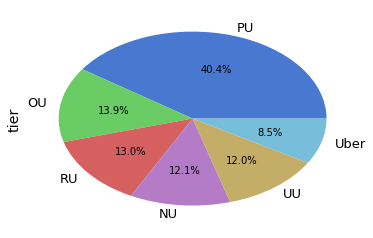

In [664]:
ax = df.tier.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('muted'))
print('Total number of Pokemon: ', len(df))

All the upper tiers are similar in size by design, but the PU tier is a dump of all the least used pokemon. We must account for this later. Let's create a dictionary with the sizes of each tier for reference:

In [665]:
tier_size = { t:len(df[df.tier == t]) for t in tiers}
tier_size

{'NU': 67, 'OU': 77, 'PU': 223, 'RU': 72, 'UU': 66, 'Uber': 47}

### Pokemon Offensive/Defensive Stats <a class="anchor" id="poke-stats"></a>

To start, let's look at the univariate and bivariate distirbutions of all the stats:

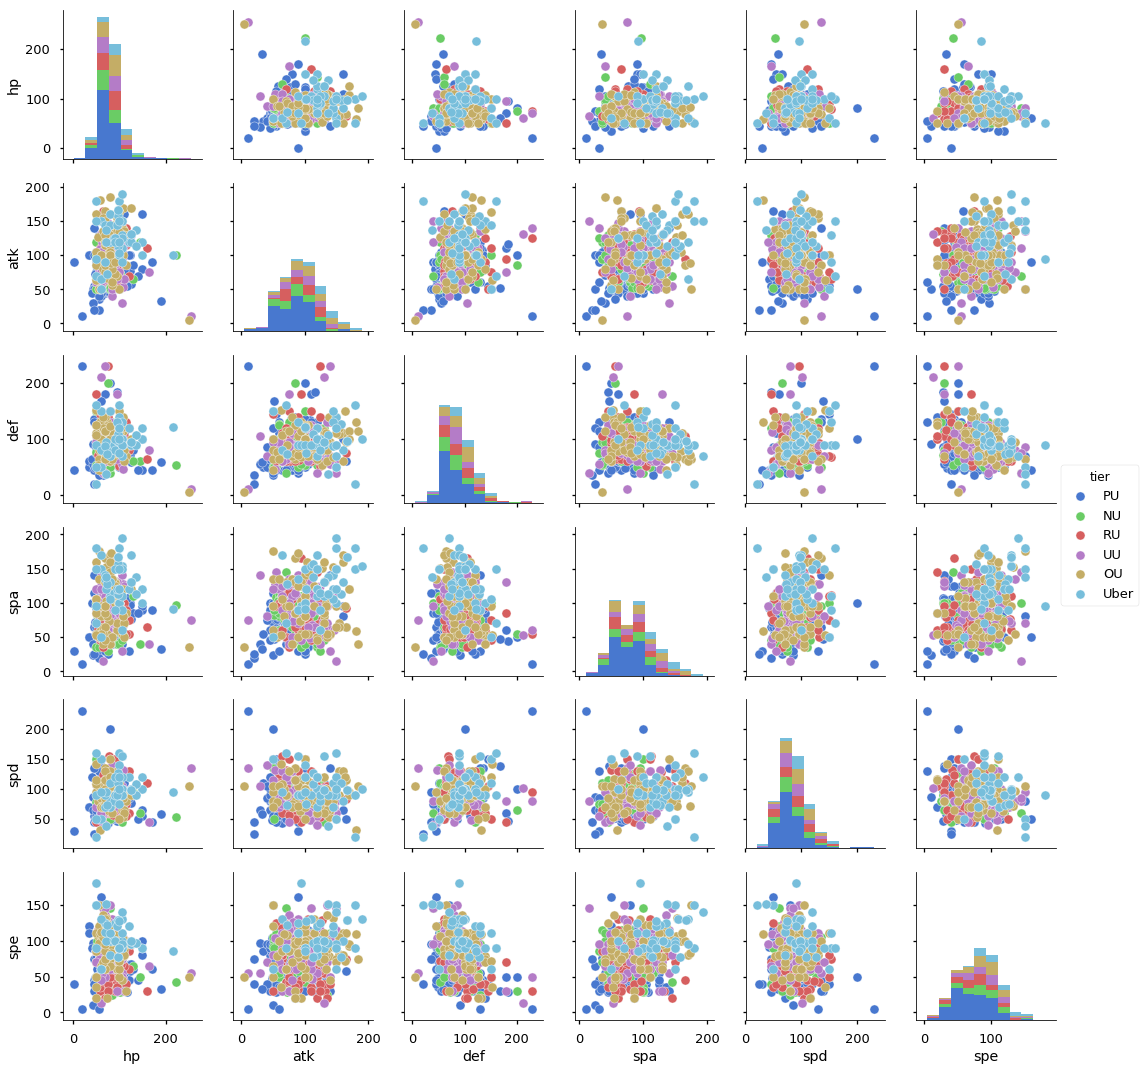

In [666]:
stats_df = df[['tier', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']] #'tier_num', , 'bst'
sns.pairplot(stats_df, hue='tier', hue_order=list(reversed(tiers)), palette="muted")

There are no obvious bivariate relationships, however some interesting properties of the stats themselves that hold true across all tiers. All the defensive stats (hp, def, spd) are skewed to the left, while the offensive (atk, spa, spe) are more balanced. Also, spa looks appears bimodal.

Let's examine how the the average stats compare for each tier:

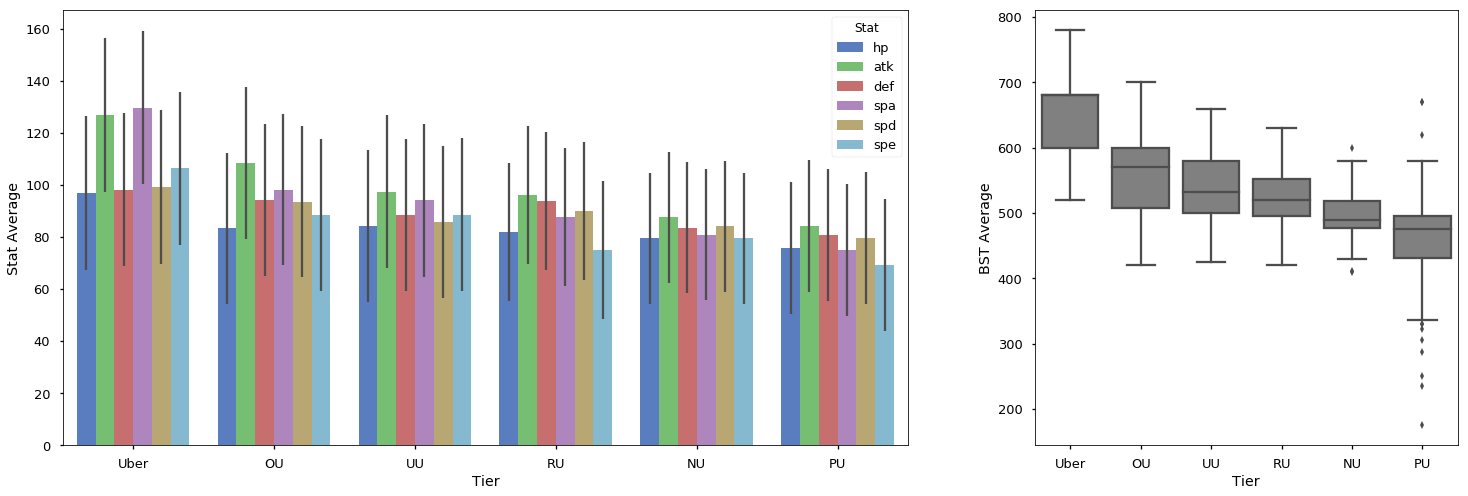

In [814]:
stats_df = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe', 'bst']].groupby(['tier', 'tier_num']).agg(np.mean)
stats_df = stats_df.reset_index()
stats_df = stats_df.melt(id_vars=['tier', 'tier_num']).sort_values('tier_num', ascending=True)
stats_df.columns = ('Tier', 'tier_num', 'Stat', 'Average')

# Seaborn can only assign a y-error per category (not hue), so we'll average the standard deviations
# All the standard deviations were quite close anyway, we would not have been able to differentiate them visually
error_df = df[['tier', 'tier_num', 'hp', 'atk', 'def', 'spa', 'spd', 'spe']].groupby(['tier', 'tier_num']).agg(np.std)
error_df = error_df.reset_index()
error_df = error_df.melt(id_vars=['tier', 'tier_num']).sort_values('tier_num', ascending=True)
error_df = error_df.groupby(['tier', 'tier_num']).agg(np.mean).sort_values('tier_num', ascending=True)
error = list(error_df.value)

sns.set_context('talk')
fig, ax = plt.subplots(1,2, figsize=(25,8), gridspec_kw = {'width_ratios':[2, 1]})
g = sns.factorplot(x="Tier", y="Average", hue_order=['hp', 'atk', 'def', 'spa', 'spd', 'spe'], hue="Stat", 
                 data=stats_df, kind="bar", palette="muted", ax=ax[0], yerr=error, ecolor=(0.3, 0.3, 0.3, 1))
g2 = sns.boxplot(data=df, x='tier', y='bst', order=tiers, color='grey', ax=ax[1])
#g2=sns.factorplot(x="Tier", y="Average", hue_order=['bst'],hue="Stat", data=temp2,
#                   kind="bar", palette="muted", aspect=1.5,  ax=ax[1])
ax[0].set(xlabel='Tier', ylabel='Stat Average')
ax[1].set(xlabel='Tier', ylabel='BST Average')
plt.close(g.fig)

Note the different scales. As expected, there is a correlation between how the level of the tier and the pokemon's stats. Interestingly, attack and special attack stats tend to become more prominent in the higher tiers, indicating a more offensive playstyle in these tiers. Also, RU seems to have a lower average speed than NU but higher defensive stats than UU, indicating a particularly defensive playstyle in this tier. 

These trends are not statistically significant, as the standard deviation for the BST and all the stats is quite high. This will make classification using stats more difficult.

In competitive pokemon, there are various user-made classifications of pokemon that describe the distribution of their stats and typical movesets. For example, a pokemon with high special/attack and speed stats is typically a sweeper; high HP and defense(s) is a wall; high special/attack and reasonable defenses with low speed is a tank; and etc. 

All the tiers tend to have all the different classifications, so it is unlikely that we will be able to cluster based on stats alone. Let's use Principal Component Analysis to plot all the stats onto a 2D scatter plot to see if this is true.

Variation per principal component: [0.28036344 0.2397493  0.1916674  0.13833584 0.09038911 0.05949491]


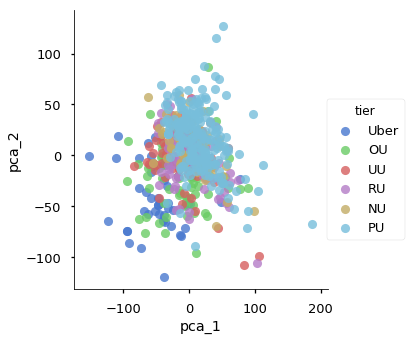

In [668]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_result = pca.fit_transform(df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']].values)
pca_df = df.copy()
pca_df = pca_df[['tier']]
pca_df['pca_1'] = pca_result[:,0]
pca_df['pca_2'] = pca_result[:,1] 
pca_df['pca_3'] = pca_result[:,1]
print(f'Variation per principal component: {pca.explained_variance_ratio_}')
sns.lmplot(data = pca_df, x='pca_1', y='pca_2', hue='tier', hue_order=tiers, fit_reg=False, palette='muted')
#sns.pairplot(pca_df, hue='tier', hue_order=tiers, palette='muted')

The first two components make up about 52% of the variance; however, as expected, it is hard to distinguish any meaningful relationships. Though there some information, as the weakest tier, PU, dominates the bottom left while the highest tier, Uber, dominates the upper right. This likely represents the magnitude of the stats of the pokemon in those tiers moreso than the distributions themselves.

### Types <a class="anchor" id="types"></a>

Moving away from the pokemon stats, let's look at the types. Both Pokemon can have one or two types while moves have one type. A  move of a given type can be super effective (2x damage), effective (1x damage), not very effective (0.5x damage), or ineffective (0x damage) against another type. When a pokemon has two types, this effect can be compounded (ie 4x damage or 0.25x damage). This is summarized in the table below from https://rankedboost.com/pokemon-sun-moon/type-chart/:

<img src="type-chart.jpg">

This means that certain types and type combinations are advantageous defensively and/or offensively. Let's create a heatmap of the overall distribution of type combinations for pokemon, then heatmaps describing the distribution relative to the overall distribution.

[Text(0.5,1,'Frequency of Type Combinations')]

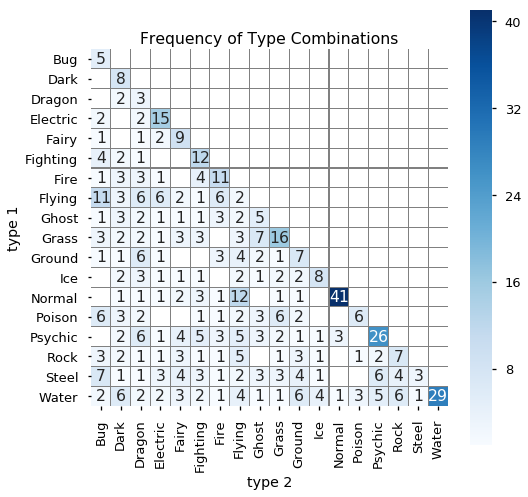

In [669]:
df['type 1'] = df.apply(lambda x: sorted(x['types'])[0], axis=1)
df['type 2'] = df.apply(lambda x: sorted(x['types'])[-1], axis=1) #if a pokemon has a single type, type 2 = type 1

type_df = df[['type 2', 'type 1']].groupby(['type 2', 'type 1']).size().reset_index()
type_df.columns = ['type 1', 'type 2', 'count']
type_pivoted_df = type_df.pivot('type 1', 'type 2', 'count')

plt.subplots(figsize=(8,8))
sns.heatmap(type_pivoted_df, annot=True, square=True, cmap='Blues', linecolor='grey', linewidths='0.05')
plt.gca().set(title='Frequency of Type Combinations')


This alone is not particularly interesting, except for the fact that purely Normal, Water, and Psychic type pokemon are very common. With a much larger dataset, the frequencies per tier would be interesting, but on this small set with many unique type combinations, the frequencies per tier would not contain much information. Instead, let's look at the overall frequencies of individual types:

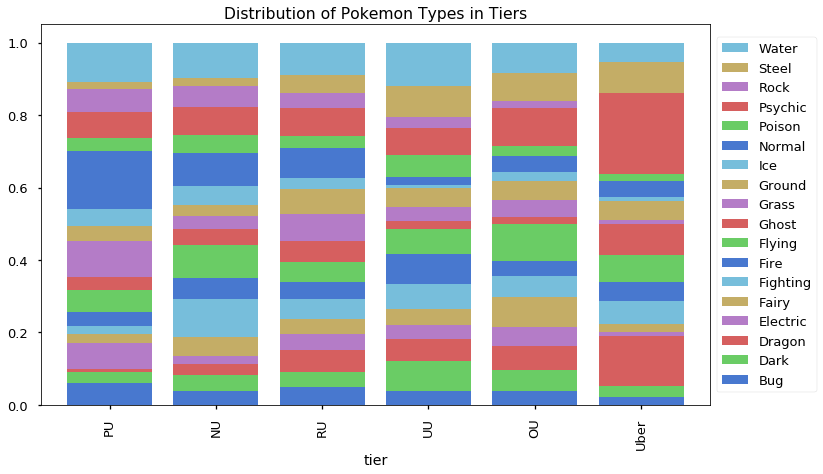

In [670]:
#Get individual counts of type1 and type 2
type1_count = df[['tier', 'type 1']].groupby(['tier', 'type 1']).size().reset_index()
type2_count = df[['tier', 'type 2']].groupby(['tier', 'type 2']).size().reset_index()
type1_count.columns=['tier', 'type', 'count1']
type2_count.columns=['tier', 'type', 'count2']

#Get overall type frequency per tier
type_count = pd.merge(type1_count, type2_count, on=['tier', 'type'], how='outer')
type_count.fillna(value=0, inplace=True)
type_count['count'] = type_count['count1'] + type_count['count2']
type_count_ind = type_count.set_index(['tier','type'])
type_count['count'] = type_count.apply(lambda x: x['count']/np.sum(type_count_ind.loc[x['tier'], 'count'])
                                      , axis=1) # /np.sum(type_count_ind2.loc[x['tier'], 'count'])

#Format Table and Sort rows
type_count = type_count[['tier','type','count']]
type_count = type_count.set_index(['tier','type']).unstack()['count']
type_count['tier_nums'] = type_count.apply(lambda x: tier_mapping[x.name],axis=1)
type_count = type_count.sort_values(by='tier_nums', ascending=False)
del type_count['tier_nums']

#Plit
type_count.plot.bar(stacked=True, title='Distribution of Pokemon Types in Tiers', 
                     legend=False, figsize=(12, 7), sort_columns=True, width=0.8,
                    color=sns.color_palette('muted'))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), handles=handles[::-1])

The stronger the tier, the more prominent dragon, psychic, and steel types are. The weaker the tier, the more prominent normal and grass types are. The distribution of steel, dragon, and grass types can be partly explained by their type advantages: dragon is an effective offensive type, steel is an effective defensive type, and grass is poor at both. However, this distribution is caused by the bias of the game developers. For example, "legendary" pokemon tend to be part dragon or psychic types.

Next, let's take a look at pokemon moves and abilities. An individual pokemon may only have one ability out of one, two, or three options (depending on the pokemon). Similarly, an individual pokemon may have up to four moves in its moveset out of many.

### Moves <a class="anchor" id="moves"></a>

There are certain moves that make otherwise mediocre pokemon powerful, such as the Shell Smash on Cloyster. There are also many exclusive moves that give pokemon an upper hand. Most moves, however, are pretty standard and are learned by a wide range of pokemon.

Let's first take a look at the distribution of how many pokemon learn particular moves.

In [671]:
mdf.set_index('name', inplace=True)

mdf['uber count'] = 0
mdf['ou count'] = 0
mdf['uu count'] = 0
mdf['ru count'] = 0
mdf['nu count'] = 0
mdf['pu count'] = 0

for ind, row in df.iterrows():
    for move in row.moves:
        mdf.loc[move, row.tier.lower() + ' count'] += 1
        
mdf['count'] = mdf['uber count'] + mdf['ou count'] + mdf['uu count'] + mdf['ru count'] + mdf['nu count'] + mdf['pu count']
#mdf = mdf.reset_index()

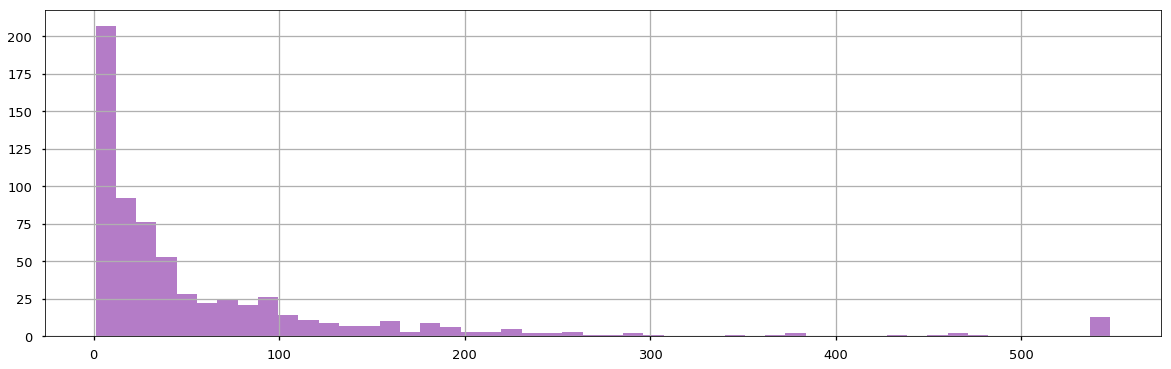

In [672]:
plt.figure(figsize=(20, 6))
mdf['count'].hist(bins=50, color=sns.color_palette('muted')[3])

Suprisingly, moves that are relatively exclusive are far more frequent than commons. Let's take a closer look at the most and least commonly learned moves.'

In [673]:
mdf.nlargest(20, 'count').index

Index(['Substitute', 'Hidden Power', 'Toxic', 'Protect', 'Sleep Talk',
       'Return', 'Frustration', 'Double Team', 'Round', 'Confide', 'Swagger',
       'Facade', 'Rest', 'Giga Impact', 'Secret Power', 'Snore', 'Hyper Beam',
       'Attract', 'Sunny Day', 'Rain Dance'],
      dtype='object', name='name')

As expected, the most common moves are common moves learned by TM. Many are quite useful in competitive battle, but are not useful in distinguishing tiers. Let's look at the least commonly learned moves. We must remember the inconsistency we found when processing the data.

In [674]:
mdf.nsmallest(20, 'count').index

Index(['Lovely Kiss', 'Sketch', 'Aeroblast', 'Doom Desire', 'Chatter',
       'Judgment', 'Attack Order', 'Defend Order', 'Heal Order',
       'Roar of Time', 'Spacial Rend', 'Lunar Dance', 'Crush Grip',
       'Magma Storm', 'Dark Void', 'Heat Crash', 'Head Charge', 'Gear Grind',
       'Searing Shot', 'Techno Blast'],
      dtype='object', name='name')

Many of these moves are the signature moves of legendary pokemon, but there are moves such as Chatter which belongs to Chatot, a PU pokemon. We'll consider a move exclusive if 3 or fewer pokemon learn it (this accomodates evolutionary lines, mega evolutions, and alternate forms).

Consider the percentage of pokemon from each tier learn a given exclusive move. Let's visualize this distribution

[Text(0.5,1,'Distribution for All Moves')]

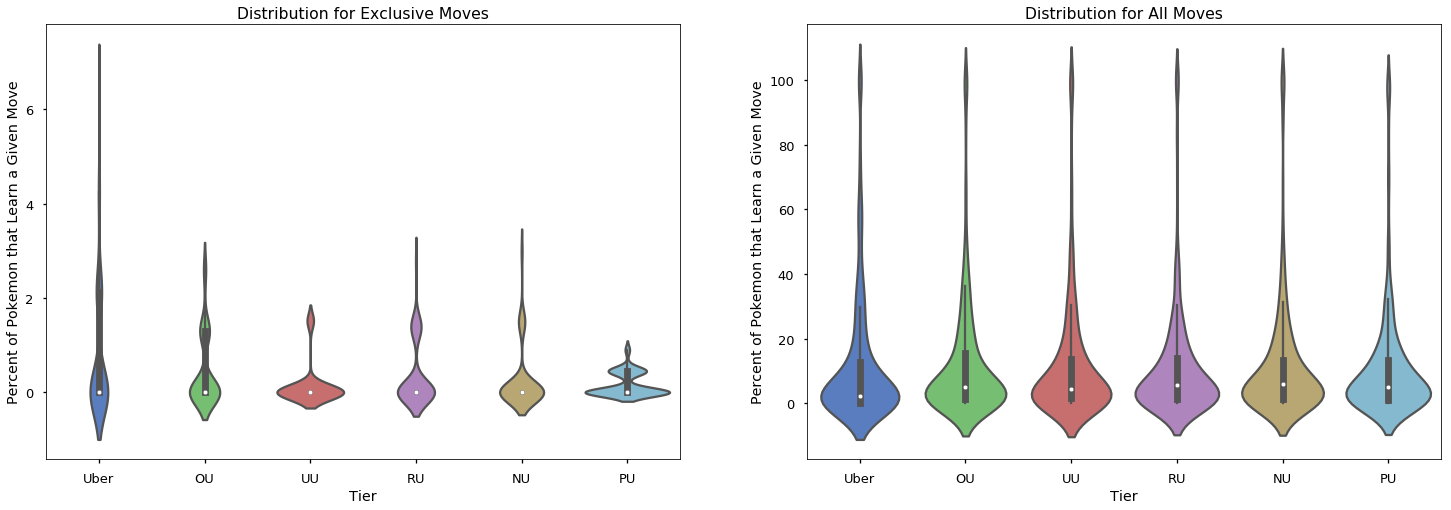

In [850]:
for t in tiers:
    mdf[t + ' %'] = mdf[t.lower() + ' count']/tier_size[t]*100

exclusives = mdf[mdf['count'] <= 3][[t + ' %' for t in tiers]].unstack().reset_index()
del exclusives['name']
exclusives.columns=['Tier', 'Percent of Pokemon that Learn a Given Move']
exclusives['Tier'] = exclusives.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

normals = mdf.copy()[[t + ' %' for t in tiers]].unstack().reset_index()
del normals['name']
normals.columns=['Tier', 'Percent of Pokemon that Learn a Given Move']
normals['Tier'] = normals.apply(lambda x: x['Tier'].split(' ')[0], axis=1)

fig, ax = plt.subplots(1,2, figsize=(25,8))
sns.violinplot(data=exclusives, x='Tier', y='Percent of Pokemon that Learn a Given Move', palette='muted', ax=ax[0])
sns.violinplot(data=normals, x='Tier', y='Percent of Pokemon that Learn a Given Move', palette='muted', ax=ax[1])
ax[0].set(title='Distribution for Exclusive Moves')
ax[1].set(title='Distribution for All Moves')

The distrbutions are interesting. For overall moves, as expected, the distributions of pokemon that learn a given move are nearly identical. Far more pokemon in the Ubers have exclusives than any other tier, which makes sense as many legendaries with exclusive moves belong to this tier (most of the rest of the legendaries are in OU). The dip seen in UU and PU for exclusive moves can be attributed to some "vanity" exclusvies that are given to weaker pokemon in lower tiers that are not extraordinary in battle.

Let's see how typical moves are distrbuted between the tiers in a heatmap.

Text(0.5,0.98,'Distribution of Percent of Pokemon that Learn in Move by Tier')

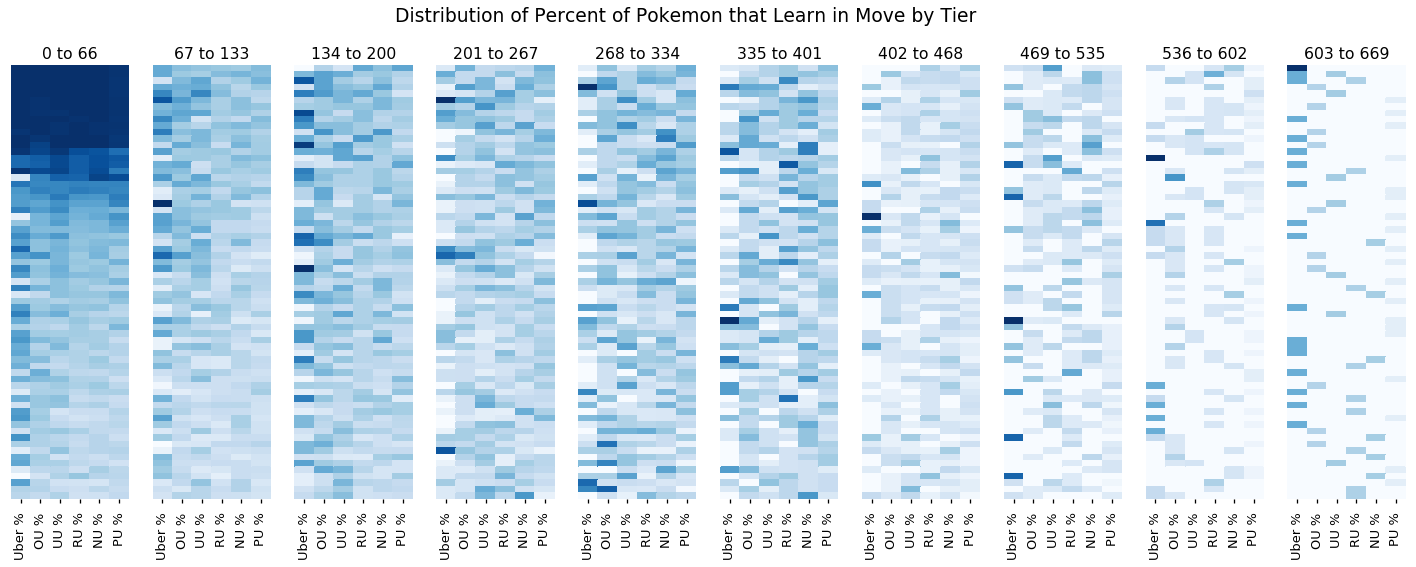

In [676]:
num_plots = 10
fig, ax = plt.subplots(1,num_plots, figsize=(25,8))

heatmap_df = mdf.sort_values('count', ascending=False)[[t + ' %' for t in tiers]]
num_elem = len(heatmap_df)
split_heat_df = []

for i in range(0, num_elem, int(num_elem/num_plots)):
    split_heat_df.append(heatmap_df.iloc[i:i+int(num_elem/num_plots)])

for hdf, axis, i in zip(split_heat_df, ax, range(0, num_elem, int(num_elem/num_plots))):
    sns.heatmap(data=heatmap_df.iloc[i:i+int(num_elem/num_plots)], 
                annot=False, cmap='Blues', ax = axis, cbar=False)
    axis.get_yaxis().set_visible(False)
    axis.set(title="{} to {}".format(i, i+int(num_elem/num_plots)-1))
    
fig.suptitle('Distribution of Percent of Pokemon that Learn in Move by Tier')

For the top 200 most common moves, the distribution is less even for the Ubers than other tiers, and it has more exclusive moves. Apart from this, there is no obvious pattern that will help us classify pokemon into tiers.

Based on this information, let's create a feature describing the number of "exclusive" moves a pokemon can learn. This seems to be the only valuable indicator from the moves.

In [860]:
exclusive_moves = set(mdf[mdf['count'] <= 3].index)
df['num_exclusive'] = 0
for ind, row in df.iterrows():
    df.loc[ind, 'num_exclusive'] += len(exclusive_moves.intersection(row.moves))